
# Harpeth River Water Level Predictions


### This script is used to predict the Harpeth River heights based on the previous days heights and precipitation for the region. Both river data and precipitation data are from below Franklin, TN. This script uses two models to predict the river heights, one model is for the days in which it rains, and another is for the days it does not.



### Naming convention: 
### Water - River data, heights
### Precip - Weather data, precipitation
### PredictWeather - Weather Predictions
### PredictWater - Predicted water data
                       


## Section 1: Import needed packages, connect to SQL DB, and get raw data

In [1]:
import pyodbc as pyodbc
import pandas as pd
import numpy as np
import requests
import json
import dpath.util
from datetime import date
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#Define figure size
plt.rcParams["figure.figsize"] = (18,10)

In [2]:
#Connect to SQL DB
connection = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-1SCLIO6;'
                      'Database=RiverHeightPrediction;'
                      'Trusted_Connection=yes;')


#Get Historical Data from SQL DB to create Model
Water_Precip = pd.read_sql_query('with River as '\
'( '\
'Select cast(datetime as date) as Date, Avg(GaugeHeight) as GaugeHeight, Avg(FlowRate) as FlowRate '\
'from riverdata '\
'group by cast(datetime as date) '\
') '\

'select River.Date as Date,  GaugeHeight, Precipitation, lag(GaugeHeight) over(order by River.Date) as PrevGauge '\
'from River join HistoricalWeatherData weather on River.date = weather.date '\
'order by river.date asc', connection)


## Section 2: Display data to identify relationships

## Create data sets for splitting up for the ascending and descending models

In [3]:
#AVG data set

#remove NA values created from the lag function
Water_Precip = Water_Precip.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

#Add column of derivative of gaugeheight
Water_Precip['DeltaGauge'] = Water_Precip.GaugeHeight - Water_Precip.PrevGauge

#Find Seed Prevgauge value for predictions - using the gaugeheight of 2021-01-25
PrevGaugeDF = Water_Precip.iloc[2:3, 1:2]
PrevGauge = PrevGaugeDF.iloc[0]['GaugeHeight']

#Remove Dates prior to 2021-01-25, incomplete weather data
Water_Precip = Water_Precip[Water_Precip["Date"] >= '2021-01-26']

#Filter out non-precip days for ascending model
Water_Precip_AscendingWater = Water_Precip[Water_Precip["Precipitation"] > 0]

#Filter out precip days for descendign model
Water_Precip_DescendingWater = Water_Precip[Water_Precip["Precipitation"] == 0]


In [4]:
#AVG data set
X_desc = Water_Precip_DescendingWater[['PrevGauge']]
y_desc = Water_Precip_DescendingWater['GaugeHeight']

X_asc = Water_Precip_AscendingWater[['Precipitation']]
y_asc = Water_Precip_AscendingWater['DeltaGauge']


Text(0.5, 1.0, 'GaugeHeight and PrevGauge')

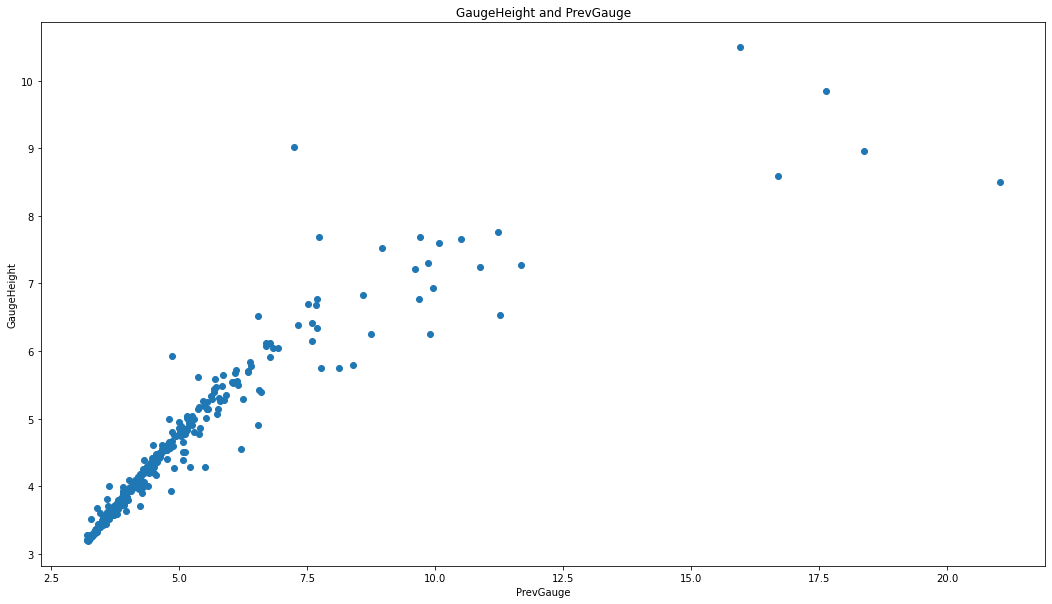

In [5]:
plot = plt.scatter(X_desc, y_desc)
plt.xlabel('PrevGauge')
plt.ylabel('GaugeHeight')
#plt.xlim([3, 5])
#plt.ylim([3, 5])
#Define figure size
plt.rcParams["figure.figsize"] = (10,10)
plt.title("GaugeHeight and PrevGauge")

Text(0.5, 1.0, 'DeltaGauge and Precipitation')

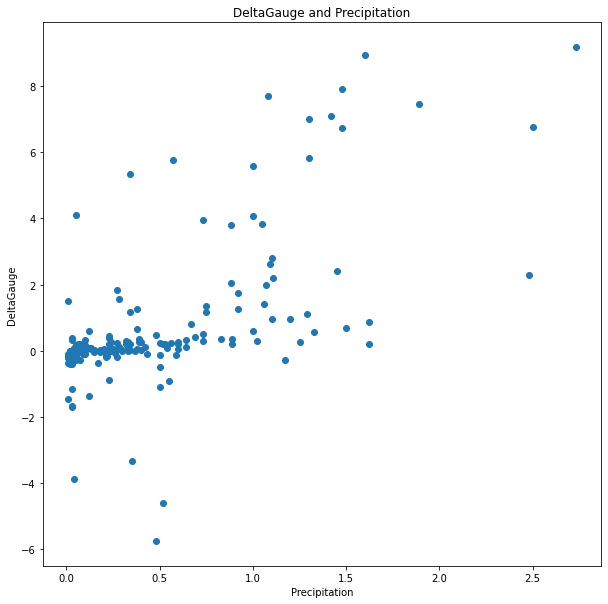

In [6]:
plot = plt.scatter(X_asc, y_asc)
plt.xlabel('Precipitation')
plt.ylabel('DeltaGauge')
plt.title("DeltaGauge and Precipitation")

## Section 3: Run Regressions

### Run descending(non-rain days) regression

In [7]:

#Run polynomial regression with order of 2
polyregdesc=make_pipeline(PolynomialFeatures(2),LinearRegression())
polyregdesc.fit(X_desc,y_desc)

print(polyregdesc.score(X_desc, y_desc))

0.9315212104815161


### Run  ascending (rain days) regression

In [8]:

#Run polynomial regression with order of 2
polyregasc=make_pipeline(PolynomialFeatures(2),LinearRegression())
polyregasc.fit(X_asc,y_asc)

print(polyregasc.score(X_asc, y_asc))

0.4272293209918989


## Section 4: Use regressions to predict historical water data

In [9]:

WaterPredicted = Water_Precip[['Date', 'GaugeHeight', 'Precipitation']]
WaterPredicted["PrevGauge"] = None
WaterPredicted["PredictedGauge"] = None

WaterPredicted = WaterPredicted.to_numpy()

C:\Users\ryder\AppData\Local\Temp/ipykernel_18704/2704011767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WaterPredicted["PrevGauge"] = None


In [10]:

#Loop through entire data set and use models to predict gauge height for that specific day
rows, cols = WaterPredicted.shape
FitValues = np.empty([1, 1])
i = 0

while(i < rows):
    WaterPredicted[i,3] = PrevGauge
    
    #Ascending regression, pass Precip to regression, find DeltaG, add to prevgauge
    if WaterPredicted[i,2] != 0:
            FitValues[0,0] = WaterPredicted[i,2]
            DeltaG = polyregasc.predict(FitValues)
            WaterPredicted[i,4] = PrevGauge + DeltaG[0]
    
    #Descending regression, pass prevgauge to reg, find GaugeHeight
    else:
            FitValues[0,0] = WaterPredicted[i,3]
            GaugeHeight = polyregdesc.predict(FitValues)
            WaterPredicted[i,4] = GaugeHeight
    
    PrevGauge = WaterPredicted[i,4]
    i+=1

In [11]:

WaterPredicted = pd.DataFrame(WaterPredicted, columns = ['Date','GaugeHeight','Precip','Prevgauge', 'PredictedGauge'])

### Plot shows real time series data along with predicted time series data, predicted data was created using the initial conditions of the first day in the data set. This is not valid for true testing as the data the predictions are compared to was part of the training data set.

Text(0, 0.5, 'GaugeHeight')

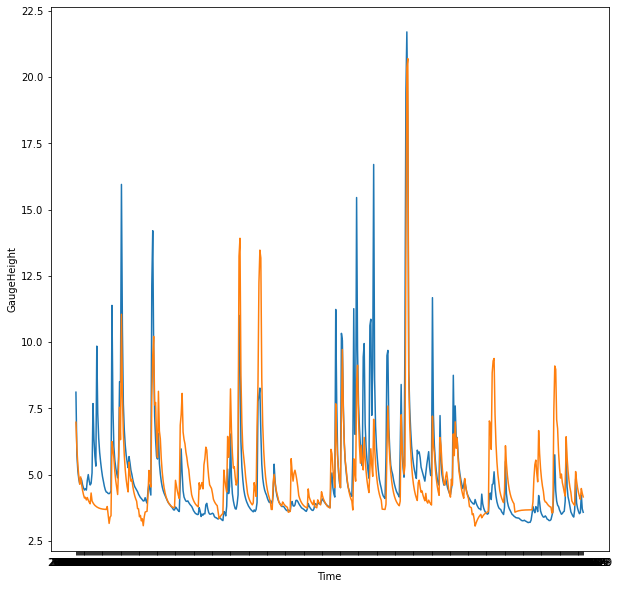

In [12]:

plot = plt.plot(WaterPredicted['Date'], WaterPredicted['GaugeHeight'])
plot = plt.plot(WaterPredicted['Date'], WaterPredicted['PredictedGauge'])
plt.xlabel('Time')
plt.ylabel('GaugeHeight')

# Section 5: Predicted weather data load - get precip forecast to make predictions

In [26]:
#Gather API keys from JSON file. Not hardcoded for security purposes
with open('C:/Users/ryder/Desktop/RiverPredictions/MyKeys.json', 'r') as file:
  MyKeys = json.load(file)

WeatherBitIOKey = dpath.util.get(MyKeys, 'WeatherBitIO')

In [27]:
#https://api.weatherbit.io/v2.0/forecast/daily?city=Raleigh,NC&key=API_KEY
    
url = "https://api.weatherbit.io/v2.0/forecast/daily?city=Franklin,TN&Units=I&key=" + WeatherBitIOKey
response = requests.get(url)

#Convert data to dictionaries
WeatherResponse = json.loads(response.content)

In [29]:
WeatherResponse

{'city_name': 'Franklin',
 'country_code': 'US',
 'data': [{'app_max_temp': 49.1,
   'app_min_temp': 27,
   'clouds': 42,
   'clouds_hi': 55,
   'clouds_low': 4,
   'clouds_mid': 31,
   'datetime': '2022-12-04',
   'dewpt': 32.2,
   'high_temp': 46.3,
   'low_temp': 32.7,
   'max_dhi': None,
   'max_temp': 42.8,
   'min_temp': 33.6,
   'moon_phase': 0.928079,
   'moon_phase_lunation': 0.37,
   'moonrise_ts': 1670185678,
   'moonset_ts': 1670148913,
   'ozone': 263.4,
   'pop': 20,
   'precip': 0,
   'pres': 997.4,
   'rh': 78,
   'slp': 1022.5,
   'snow': 0,
   'snow_depth': 0,
   'sunrise_ts': 1670157748,
   'sunset_ts': 1670193231,
   'temp': 38.4,
   'ts': 1670180460,
   'uv': 0,
   'valid_date': '2022-12-04',
   'vis': 11.9,
   'weather': {'code': 803, 'icon': 'c03d', 'description': 'Broken clouds'},
   'wind_cdir': 'S',
   'wind_cdir_full': 'south',
   'wind_dir': 175,
   'wind_gust_spd': 3.8,
   'wind_spd': 2.9},
  {'app_max_temp': 51.8,
   'app_min_temp': 28.9,
   'clouds': 87,


In [30]:
#Declare iterating variable and create empty numpy array to store values retrieved from JSON
i = 0
PredictedWeather = np.empty([1,2])

#API returns 7 days of forecasted weather
while i<=6:
    
    str1 = 'data/' + str(i) + '/precip'
    str2 = 'data/' + str(i) + '/valid_date'
    #Append values to ndarray using dpath.util to extract JSON
    PredictedWeather = np.append(PredictedWeather, [[dpath.util.get(WeatherResponse, str2), dpath.util.get(WeatherResponse, str1)]], axis = 0 )
    
    i+=1
    
PredictedWeather = np.delete(PredictedWeather, 0, 0)

In [31]:
PredictedWeather = pd.DataFrame(PredictedWeather, columns = ['Date', 'Precipitation'])

## Section 6: Use weather and regressions to predit river levels

In [32]:
PredictedWater = PredictedWeather

In [33]:
PredictedWater["PrevGauge"] = None
PredictedWater["PredictedGauge"] = None

PredictedWater = PredictedWater.to_numpy()

In [34]:
PrevGauge = pd.read_sql_query('Select cast([Datetime] as date)as \'Date\' , avg(Gaugeheight) as Gaugeheight '\
'From riverdata '\
'Where cast([datetime] as date) = dateadd(day, -1, cast(getdate() as date)) '\
'group by cast([datetime] as date) '\
'order by cast([datetime] as date) ', connection)



In [35]:
#Find Seed Prevgauge value for predictions - using the gaugeheight of yesterday - dateadd done in SQL server
PrevGaugeDF = PrevGauge.iloc[0:1, 1:2]
PrevGauge = PrevGaugeDF.iloc[0]['Gaugeheight']

In [36]:
#Loop through entire data set and use models to predict gauge height for that specific day
rows, cols = PredictedWater.shape
FitValues = np.empty([1, 1])
i = 0

while(i < rows):
    PredictedWater[i,2] = PrevGauge
    
    #Ascending regression, pass Precip to regression, find DeltaG, add to prevgauge
    if PredictedWater[i,1] != '0':
            FitValues[0,0] = PredictedWater[i,1]
            DeltaG = polyregasc.predict(FitValues)
            PredictedWater[i,3] = PrevGauge + DeltaG[0]
    
    #Descending regression, pass prevgauge to reg, find GaugeHeight
    else:
            FitValues[0,0] = PredictedWater[i,2]
            GaugeHeight = polyregdesc.predict(FitValues)
            PredictedWater[i,3] = GaugeHeight
    
    PrevGauge = PredictedWater[i,3]
    i+=1

In [37]:
PredictedWater = pd.DataFrame(PredictedWater, columns = ['Date','Precipitation','Prevgauge', 'PredictedGauge'])

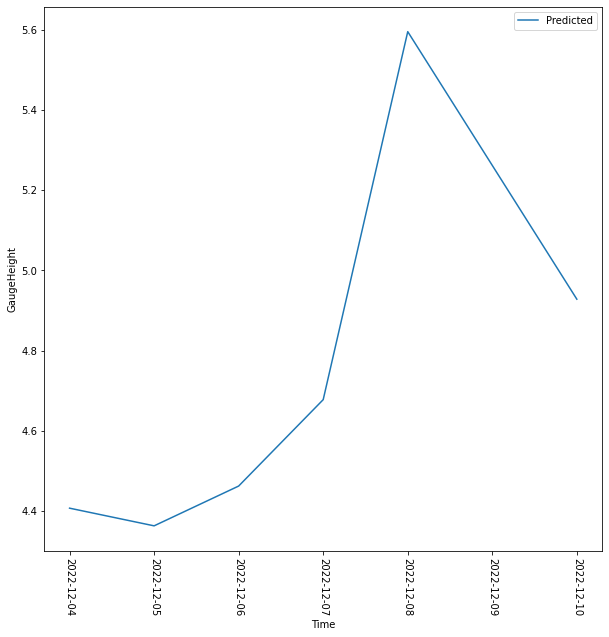

In [38]:

plot = plt.plot(PredictedWater['Date'], PredictedWater['PredictedGauge'])
plt.xlabel('Time')
plt.ylabel('GaugeHeight')
plt.xticks(rotation = -90)
plt.legend(['Predicted'])

### The following is used to troubleshoot the models accuracy at low river levels

In [39]:
#testvalues = np.empty([50, 1])
#testvalues
testvalues = np.arange(3,20,.05)
testvalues = testvalues.reshape(-1, 1)

In [40]:
Y = polyregdesc.predict(testvalues)

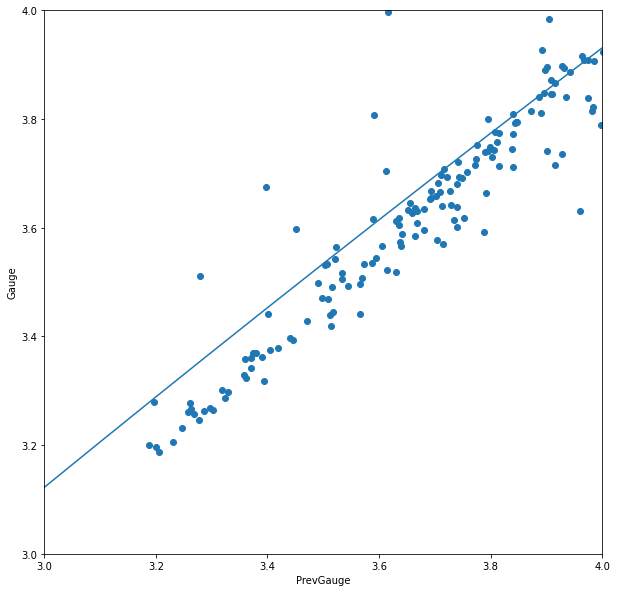

In [41]:
plot = plt.scatter(X_desc, y_desc)
plt.xlabel('PrevGauge')
plt.ylabel('Gauge')
plt.plot(testvalues, Y)
plt.xlim([3, 4])
plt.ylim([3, 4])
#Define figure size
plt.rcParams["figure.figsize"] = (10,10)